In [1]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# Gestión de carteras

In [2]:
import math
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

## Descarga de precios

In [3]:
filename="https://raw.githubusercontent.com/alfonso-santos/Python-aplicado-gestion-carteras/fernando/Tema_2/data/tr_eikon_eod_data.csv"
raw = pd.read_csv(filename,index_col=0, parse_dates=True)
raw.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82


## Creamos una cartera con cuatro títulos

In [4]:
symbols = ['SPY', 'GLD', 'AAPL.O', 'MSFT.O']
data = raw[symbols].dropna()
data.head()

,SPY,GLD,AAPL.O,MSFT.O
Date,,,,
2010-01-04,113.33,109.80,30.572827,30.950
2010-01-05,113.63,109.70,30.625684,30.960
2010-01-06,113.71,111.51,30.138541,30.770
2010-01-07,114.19,110.82,30.082827,30.452
2010-01-08,114.57,111.37,30.282827,30.660


Vamos a crear un índice para comparar visualmente los activos de la cartera. Dividimos los precios actuales con los del instante de tiempo inicial `data.iloc[0]`.

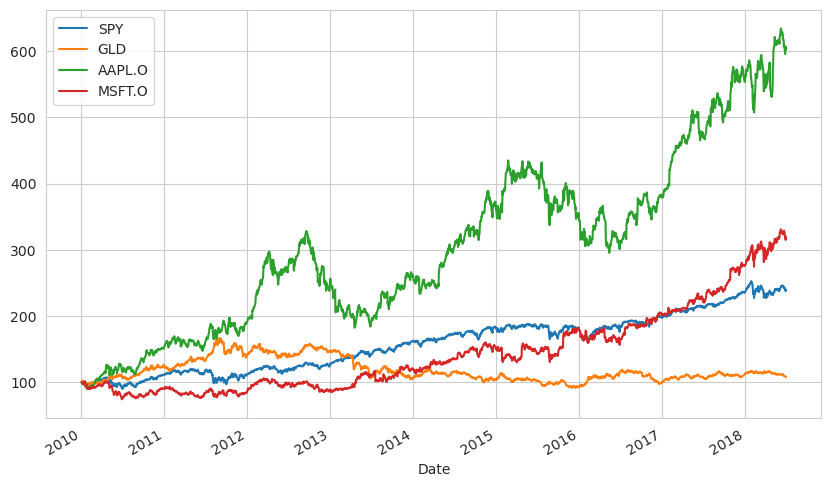

In [5]:
(data / data.iloc[0] * 100).plot(figsize=(10, 6))
plt.show()

Como siempre, vamos a calcular las rentabilidades logarítmicas y posteriormente representar sus histogramas.

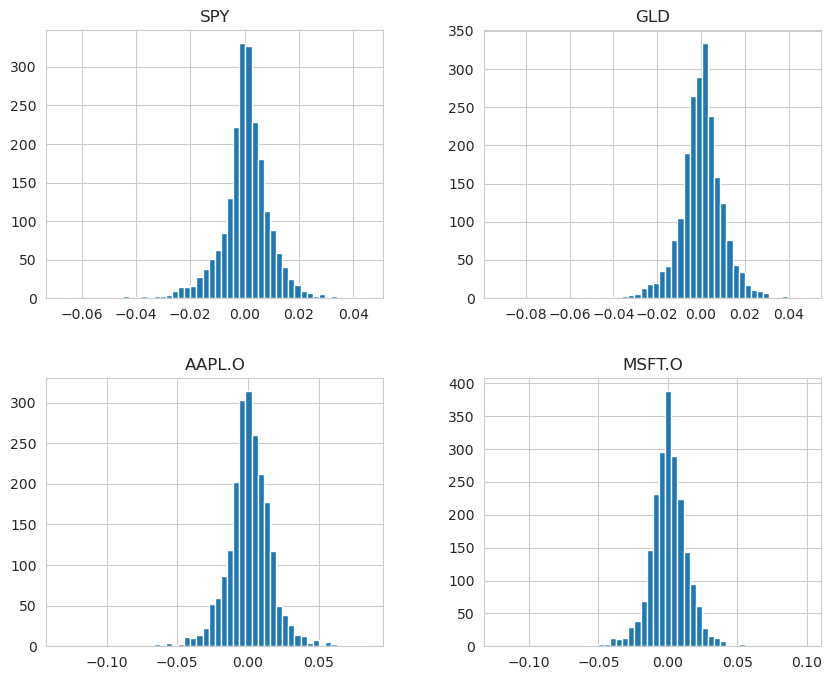

In [6]:
rets = np.log(data).diff().dropna()
rets.hist(bins=50, figsize=(10, 8))
plt.show()

Los datos están expresados en términos diarios. Para tener una representación de la rentabilidad anual, consideramos que se negocian 252 días al año.

In [7]:
retornos = rets.mean() * 252
retornos

SPY       0.102928
GLD       0.009141
AAPL.O    0.212359
MSFT.O    0.136648
dtype: float64

In [8]:
covar = rets.cov() * 252
covar

,SPY,GLD,AAPL.O,MSFT.O
SPY,0.021939,0.000062,0.021039,0.022244
GLD,0.000062,0.026209,0.001513,-0.000347
AAPL.O,0.021039,0.001513,0.063773,0.023427
MSFT.O,0.022244,-0.000347,0.023427,0.050917


Vamos a generar una cartera aleatoria con 4 pesos aleatorios. Recordad normalizar los pesos para mantener $\sum_{i=1}^4 w_i = 1$

In [9]:
num_activos = len(data.columns)
weights = np.random.rand(num_activos)
weights /= weights.sum()
print(weights)

[0.33848253 0.1444563  0.1538361  0.36322506]


Calculamos la rentabilidad de la cartera, su varianza y desviación típica.

In [10]:
r_cartera = retornos @ weights.T
r_cartera

0.11846247967418957

In [11]:
var_cartera = weights @ covar @ weights.T
var_cartera

0.02160271595926844

In [12]:
std_cartera = np.sqrt(var_cartera)
std_cartera

0.1469786241576252

Definimos un par de funciones, `port_ret(retornos, pesos)` y `port_vol(covar, pesos)` que nos permitan calcular la rentabilidad esperada de una cartera $(\mu)$ y su desviación típica $(\sigma)$.

<font color="#FF0000">NOTA CHRIS: COMENTAR CON FERNANDO np.diag de port_var</font>

In [82]:
def port_ret(retornos, pesos):
    return retornos @ pesos.T

def port_var(covar, pesos):
    # Queremos la varianza de cada cartera, por tanto nos quedamos con la diagonal
    return np.diag(pesos @ covar @ pesos.T)

def port_std(covar, pesos):
    return np.sqrt(port_var(covar, pesos))

Generamos 2500 carteras aleatorias con numpy y aplicamos las funciones anteriores para calcular los retornos de las carteras y sus volatilidades:

In [83]:
num_carteras = 2500
carteras = np.random.rand(num_carteras * num_activos).reshape(num_carteras, num_activos)
carteras = carteras / carteras.sum(axis=1, keepdims=True)
carteras.shape

(2500, 4)

In [84]:
r_carteras = port_ret(retornos, carteras)
r_carteras.shape

(2500,)

In [85]:
std_carteras = port_std(covar, carteras)
std_carteras.shape

(2500,)

Definimos el gráfico que nos muestre las 2500 carteras generadas de manera aleatoria.
- Definimos el tamaño `plt.figure(figsize=(10, 6))`
- Creamos un gráfico donde cada punto es una cartera que viene definido en el eje horizontal por las volatilidades `std_carteras` y en el eje vertical y por los retornos `r_carteras`, además le añadimos un mapa de calor con su ratio de Sharpe.

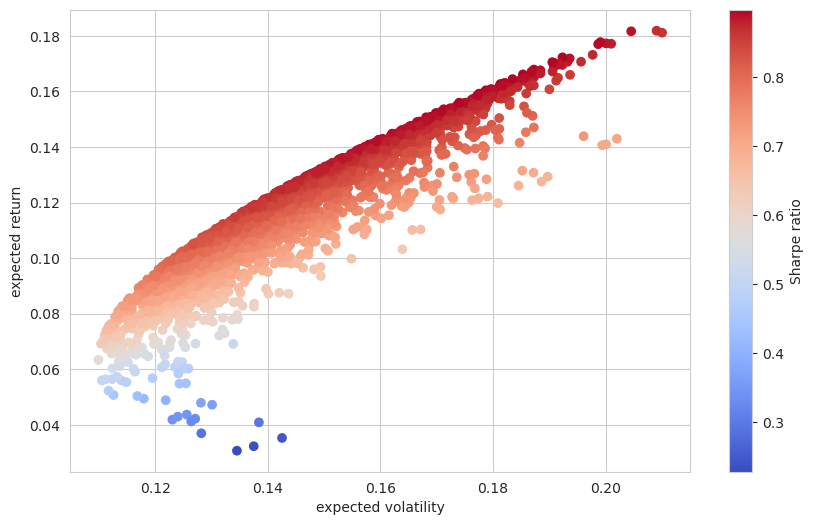

In [87]:
plt.figure(figsize=(10, 6))
plt.scatter(std_carteras, r_carteras, c=r_carteras / std_carteras, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()